## no births or deaths in this one

In [2]:
using GraphViz

using StockFlow
using StockFlow.Syntax

using Catlab
using Catlab.CategoricalAlgebra
using LabelledArrays
using OrdinaryDiffEq
using Plots

using Catlab.Graphics
using Catlab.Programs
using Catlab.WiringDiagrams

using Catlab.Graphics.Graphviz: Html
using Catlab.Graphics.Graphviz

In [31]:
# Functions for graphing typed Petri nets
colors_vflow = ["antiquewhite4","antiquewhite", "gold", "saddlebrown", "slateblue", "blueviolet", "olive"]
colors_s = ["deeppink","darkorchid","darkred","coral"] # red series
colors_sv = ["cornflowerblue","cyan4","cyan","chartreuse"] # green and blue series
colors_p = ["gold","gold4","darkorange1","lightgoldenrod","goldenrod"] # yellow and orange

flatten(fname::Symbol) = "$fname"

function flatten(fname::Tuple)
    names = split(replace(string(fname), "("=>"", ")"=>"", ":"=>""), ",")
    for i in 1:length(names)
        name = strip(names[i])
        if name[1:2] == "id"
            continue
        end
        return name
    end
    return "id"
end

def_stock(typed_StockFlow::ACSetTransformation, colors) = 
  (p,s) -> ("s$s", Attributes(:label=>sname(p,s) isa Tuple where T ? Html(replace(string(sname(p,s)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(sname(p,s))",
                                     :shape=>"square", 
                                     :color=>"black", 
                                     :style=>"filled", 
                                     :fillcolor=>colors[typed_StockFlow[:S](s)]))

def_parameter(typed_StockFlow::ACSetTransformation, colors) = 
(p, pp) -> ("p$pp", Attributes(:label=>pname(p,pp) isa Tuple where T ? Html(replace(string(pname(p,pp)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(pname(p,pp))",
                                     :shape=>"circle", 
                                     :color=>colors[typed_StockFlow[:P](pp)],
                                     :fontcolor=>colors[typed_StockFlow[:P](pp)]))

def_auxiliaryVF(typed_StockFlow::ACSetTransformation, colors)=
  (p, v) -> ("v$v", Attributes(:label=>make_v_expr(p,v) isa Tuple where T ? Html(replace(string(make_v_expr(p,v)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(make_v_expr(p,v))",
                                          :shape=>"plaintext", 
                                          :fontcolor=>colors[typed_StockFlow[:V](v)]))


def_sumV(typed_StockFlow::ACSetTransformation, colors) = 
  (p, sv) -> ("sv$sv", Attributes(:label=>svname(p,sv) isa Tuple where T ? Html(replace(string(svname(p,sv)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(svname(p,sv))",
                                       :shape=>"circle", 
                                       :color=>"black",
                                       :fillcolor=>colors[typed_StockFlow[:SV](sv)], 
                                       :style=>"filled"))  


def_flow_V(typed_StockFlow::ACSetTransformation, colors)=
  (p, us, ds, v, f) -> begin
    labelfontsize = "6"
    colorType = colors[typed_StockFlow[:F](f)]
    color = "$colorType"*":invis:"*"$colorType"
    arrowhead = "none"
    splines = "ortho"
    return ([us, "v$v"],Attributes(:label=>"", :labelfontsize=>labelfontsize, :color=>color, :arrowhead=>arrowhead, :splines=>splines)),
           (["v$v", ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>labelfontsize, :color=>color, :splines=>splines))            
end
        
def_flow_noneV(typed_StockFlow::ACSetTransformation, colors)=
  (p, us, ds, f) -> begin
     colorType = colors[typed_StockFlow[:F](f)]
     color = "$colorType"*":invis:"*"$colorType"   
     ([us, ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>"6", :color=>color))
end

def_flow_V(colors = colors_vflow)=
  (p, us, ds, v, f) -> begin
    labelfontsize = "6"
    colorType = colors[f]
    color = "$colorType"*":invis:"*"$colorType"
    arrowhead = "none"
    splines = "ortho"
    return ([us, "v$v"],Attributes(:label=>"", :labelfontsize=>labelfontsize, :color=>color, :arrowhead=>arrowhead, :splines=>splines)),
           (["v$v", ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>labelfontsize, :color=>color, :splines=>splines))            
    
end
        
def_flow_noneV(colors = colors_vflow)=
  (p, us, ds, f) -> begin
     colorType = colors[f]
     color = "$colorType"*":invis:"*"$colorType"   
     ([us, ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>"6", :color=>color))
end

GraphF_typed(typed_StockFlow::ACSetTransformation, colors_vflow = colors_vflow, colors_s = colors_s, colors_p = colors_p, colors_sv = colors_sv; schema::String="C", type::String="SFVL", rd::String="LR") = GraphF(dom(typed_StockFlow),
    make_stock = def_stock(typed_StockFlow, colors_s), make_auxiliaryV=def_auxiliaryVF(typed_StockFlow, colors_vflow), make_sumV=def_sumV(typed_StockFlow, colors_sv), 
    make_flow_V=def_flow_V(typed_StockFlow, colors_vflow), make_flow_noneV=def_flow_noneV(typed_StockFlow, colors_vflow),make_parameter=def_parameter(typed_StockFlow, colors_p),schema=schema, type=type, rd=rd
)
            
flatten(k::Nothing) = "nothing"
            
            

flatten (generic function with 4 methods)

In [39]:
sis = @stock_and_flow begin
    :stocks
    X
    I
    
    :parameters
#     δ
#     μ
    β
    trecovery
    r
    c
    
    :dynamic_variables
#     v_deathsX = X * δ
#     v_deathsI = I * δ
#     v_births = μ * N
    
    
    v_prevalence = I / N
    v_meanInfectiousContactsPerX = c * v_prevalence
    v_perXIncidenceRate = β * v_meanInfectiousContactsPerX
    v_newInfections = X * v_perXIncidenceRate
    
    v_newRecovery = I / trecovery
    v_idI = r * I
    v_idX = r * X
    
    :flows
#     CLOUD => f_births(v_births) => X
    I => f_newRecovery(v_newRecovery) => X
    X => f_idX(v_idX) => X
#     X => f_deathsX(v_deathsX) => CLOUD
    X => f_newInfectious(v_newInfections) => I
    I => f_idI(v_idI) => I
#     I => f_deathsI(v_deathsI) => CLOUD
    
    
    
    
    :sums
    N = [X, I]
#     NI = [I]
#     NS = [X, I]
    
end

StockAndFlowF with elements S = 1:2, SV = 1:1, LS = 1:2, F = 1:4, I = 1:4, O = 1:4, V = 1:7, LV = 1:5, LSV = 1:1, P = 1:4, LVV = 1:3, LPV = 1:5
┌───┬───────┐
│ S │ sname │
├───┼───────┤
│ 1 │     X │
│ 2 │     I │
└───┴───────┘
┌────┬────────┐
│ SV │ svname │
├────┼────────┤
│  1 │      N │
└────┴────────┘
┌────┬─────┬──────┐
│ LS │ lss │ lssv │
├────┼─────┼──────┤
│  1 │   1 │    1 │
│  2 │   2 │    1 │
└────┴─────┴──────┘
┌───┬────┬─────────────────┐
│ F │ fv │           fname │
├───┼────┼─────────────────┤
│ 1 │  5 │   f_newRecovery │
│ 2 │  7 │           f_idX │
│ 3 │  4 │ f_newInfectious │
│ 4 │  6 │           f_idI │
└───┴────┴─────────────────┘
┌───┬─────┬────┐
│ I │ ifn │ is │
├───┼─────┼────┤
│ 1 │   1 │  1 │
│ 2 │   2 │  1 │
│ 3 │   3 │  2 │
│ 4 │   4 │  2 │
└───┴─────┴────┘
┌───┬─────┬────┐
│ O │ ofn │ os │
├───┼─────┼────┤
│ 1 │   2 │  1 │
│ 2 │   3 │  1 │
│ 3 │   1 │  2 │
│ 4 │   4 │  2 │
└───┴─────┴────┘
┌───┬──────────────────────────────┬─────┐
│ V │                        vname │ vop │
├───┼──────────────────────────────┼─────┤
│ 1 │                 v_prevalence │   / │
│ 2 │ v_meanInfectiousContactsPerX │   * │
│ 3 │          v_perXIncidenceRate │   * │
│ 4 │              v_newInfections │   * │
│ 5 │                v_newRecovery │   / │
│ 6 │                        v_idI │   * │
│ 7 │                        v_idX │   * │
└───┴──────────────────────────────┴─────┘
┌────┬─────┬─────┬─────────────┐
│ LV │ lvs │ lvv │ lvsposition │
├────┼─────┼─────┼─────────────┤
│  1 │   2 │   1 │           1 │
│  2 │   1 │   4 │           1 │
│  3 │   2 │   5 │           1 │
│  4 │   2 │   6 │           2 │
│  5 │   1 │   7 │           2 │
└────┴─────┴─────┴─────────────┘
┌─────┬───────┬──────┬───────────────┐
│ LSV │ lsvsv │ lsvv │ lsvsvposition │
├─────┼───────┼──────┼───────────────┤
│   1 │     1 │    1 │             2 │
└─────┴───────┴──────┴───────────────┘
┌───┬───────────┐
│ P │     pname │
├───┼───────────┤
│ 1 │         β │
│ 2 │ trecovery │
│ 3 │         r │
│ 4 │         c │
└───┴───────────┘
┌─────┬───────┬───────┬───────────────┐
│ LVV │ lvsrc │ lvtgt │ lvsrcposition │
├─────┼───────┼───────┼───────────────┤
│   1 │     1 │     2 │             2 │
│   2 │     2 │     3 │             2 │
│   3 │     3 │     4 │             2 │
└─────┴───────┴───────┴───────────────┘
┌─────┬──────┬──────┬──────────────┐
│ LPV │ lpvp │ lpvv │ lpvpposition │
├─────┼──────┼──────┼──────────────┤
│   1 │    4 │    2 │            1 │
│   2 │    1 │    3 │            1 │
│   3 │    2 │    5 │            2 │
│   4 │    3 │    6 │            1 │
│   5 │    3 │    7 │            1 │
└─────┴──────┴──────┴──────────────┘

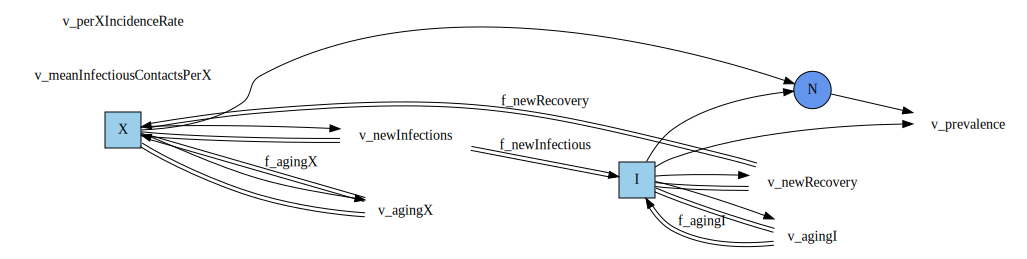

In [5]:
Graph(sis)

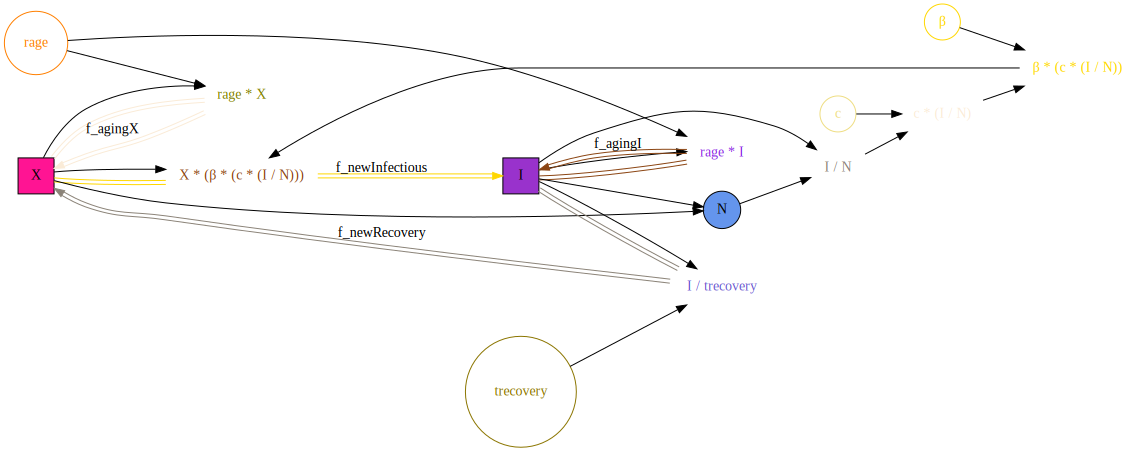

In [7]:
GraphF_typed(id(sis))

In [40]:
s_type = @stock_and_flow begin
    :stocks
    pop
    
    :parameters
    c
    β
    rFstOrder
    rAge
    
    :dynamic_variables
    v_prevalence = pop / N
    v_meanInfectiousContactsPerS = c * v_prevalence
    v_perSIncidenceRate = β * v_meanInfectiousContactsPerS
    v_inf = pop * v_perSIncidenceRate
    v_fstOrder = pop * rFstOrder
    v_aging = pop * rAge
    
    :flows
    pop => f_inf(v_inf) => pop
    pop => f_fstOrder(v_fstOrder) => pop
    pop => f_aging(v_aging) => pop

    
    :sums
    N = [pop]
    
    
end

StockAndFlowF with elements S = 1:1, SV = 1:1, LS = 1:1, F = 1:3, I = 1:3, O = 1:3, V = 1:6, LV = 1:4, LSV = 1:1, P = 1:4, LVV = 1:3, LPV = 1:4
┌───┬───────┐
│ S │ sname │
├───┼───────┤
│ 1 │   pop │
└───┴───────┘
┌────┬────────┐
│ SV │ svname │
├────┼────────┤
│  1 │      N │
└────┴────────┘
┌────┬─────┬──────┐
│ LS │ lss │ lssv │
├────┼─────┼──────┤
│  1 │   1 │    1 │
└────┴─────┴──────┘
┌───┬────┬────────────┐
│ F │ fv │      fname │
├───┼────┼────────────┤
│ 1 │  4 │      f_inf │
│ 2 │  5 │ f_fstOrder │
│ 3 │  6 │    f_aging │
└───┴────┴────────────┘
┌───┬─────┬────┐
│ I │ ifn │ is │
├───┼─────┼────┤
│ 1 │   1 │  1 │
│ 2 │   2 │  1 │
│ 3 │   3 │  1 │
└───┴─────┴────┘
┌───┬─────┬────┐
│ O │ ofn │ os │
├───┼─────┼────┤
│ 1 │   1 │  1 │
│ 2 │   2 │  1 │
│ 3 │   3 │  1 │
└───┴─────┴────┘
┌───┬──────────────────────────────┬─────┐
│ V │                        vname │ vop │
├───┼──────────────────────────────┼─────┤
│ 1 │                 v_prevalence │   / │
│ 2 │ v_meanInfectiousContactsPerS │   * │
│ 3 │          v_perSIncidenceRate │   * │
│ 4 │                        v_inf │   * │
│ 5 │                   v_fstOrder │   * │
│ 6 │                      v_aging │   * │
└───┴──────────────────────────────┴─────┘
┌────┬─────┬─────┬─────────────┐
│ LV │ lvs │ lvv │ lvsposition │
├────┼─────┼─────┼─────────────┤
│  1 │   1 │   1 │           1 │
│  2 │   1 │   4 │           1 │
│  3 │   1 │   5 │           1 │
│  4 │   1 │   6 │           1 │
└────┴─────┴─────┴─────────────┘
┌─────┬───────┬──────┬───────────────┐
│ LSV │ lsvsv │ lsvv │ lsvsvposition │
├─────┼───────┼──────┼───────────────┤
│   1 │     1 │    1 │             2 │
└─────┴───────┴──────┴───────────────┘
┌───┬───────────┐
│ P │     pname │
├───┼───────────┤
│ 1 │         c │
│ 2 │         β │
│ 3 │ rFstOrder │
│ 4 │      rAge │
└───┴───────────┘
┌─────┬───────┬───────┬───────────────┐
│ LVV │ lvsrc │ lvtgt │ lvsrcposition │
├─────┼───────┼───────┼───────────────┤
│   1 │     1 │     2 │             2 │
│   2 │     2 │     3 │             2 │
│   3 │     3 │     4 │             2 │
└─────┴───────┴───────┴───────────────┘
┌─────┬──────┬──────┬──────────────┐
│ LPV │ lpvp │ lpvv │ lpvpposition │
├─────┼──────┼──────┼──────────────┤
│   1 │    1 │    2 │            1 │
│   2 │    2 │    3 │            1 │
│   3 │    3 │    5 │            2 │
│   4 │    4 │    6 │            2 │
└─────┴──────┴──────┴──────────────┘

In [41]:
s, = parts(s_type, :S)
N, = parts(s_type, :SV)
lsn, = parts(s_type, :LS)
f_inf, f_fstorder, f_aging = parts(s_type, :F)
i_inf, i_fstorder, i_aging = parts(s_type, :I) # note, different order from previous in both inflow and outflow
o_inf, o_fstorder, o_aging = parts(s_type, :O)
v_IN, v_cIN, v_betacIN, v_inf, v_fstOrder, v_aging = parts(s_type, :V)
lv_IN1, lv_inf1, lv_fstOrder1, lv_aging1 = parts(s_type, :LV)
lsv_IN2, = parts(s_type, :LSV)
p_c, p_beta, p_rfstOrder, p_rAge = parts(s_type, :P)
lvv_cIN2, lvv_betacIN2, lvv_inf2 = parts(s_type, :LVV)
lpv_cIN1, lpv_betacIN1, lpv_fstOrder2, lpv_aging2 = parts(s_type, :LPV)

1:4

In [35]:
sis = map(sis,  Name = name -> nothing, Op=op->nothing, Position=pos->nothing);

In [14]:
s_type = map(s_type,  Name = name -> nothing, Op=op->nothing, Position=pos->nothing);

In [42]:
sis_pop_strata=ACSetTransformation(sis, s_type,
  S = [s,s],
  SV = [N],
  LS = [lsn, lsn],
F = [f_fstorder, f_aging, f_inf, f_aging],

I = [i_fstorder, i_aging, i_inf, i_aging],
O = [o_aging, o_inf, o_fstorder, o_aging],
V = [v_IN, v_cIN, v_betacIN, v_inf, v_fstOrder, v_aging, v_aging],
LV = [lv_IN1, lv_inf1, lv_fstOrder1, lv_aging1, lv_aging1],
LSV = [lsv_IN2],
P = [p_beta, p_rfstOrder, p_rAge, p_c],
LVV = [lvv_cIN2, lvv_betacIN2, lvv_inf2],
LPV = [lpv_cIN1, lpv_betacIN1, lpv_fstOrder2, lpv_aging2, lpv_aging2],
  Name = name -> nothing, Op = op -> nothing, Position = pos -> nothing
)

ACSetTransformation((S = FinFunction([1, 1], 2, 1), SV = FinFunction([1], 1, 1), LS = FinFunction([1, 1], 2, 1), F = FinFunction([2, 3, 1, 3], 4, 3), I = FinFunction([2, 3, 1, 3], 4, 3), O = FinFunction([3, 1, 2, 3], 4, 3), V = FinFunction([1, 2, 3, 4, 5, 6, 6], 7, 6), LV = FinFunction([1, 2, 3, 4, 4], 5, 4), LSV = FinFunction([1], 1, 1), P = FinFunction([2, 3, 4, 1], 4, 4), LVV = FinFunction([1, 2, 3], 3, 3), LPV = FinFunction([1, 2, 3, 4, 4], 5, 4), Name = SetFunction(#155, TypeSet(Symbol), TypeSet(Symbol)), Op = SetFunction(#156, TypeSet(Symbol), TypeSet(Symbol)), Position = SetFunction(#157, TypeSet(Int8), TypeSet(Int8))), StockAndFlowF {S = 2, SV = 1, LS = 2, F = 4, I = 4, O = 4, V = 7, LV = 5, LSV = 1, P = 4, LVV = 3, LPV = 5}, StockAndFlowF {S = 1, SV = 1, LS = 1, F = 3, I = 3, O = 3, V = 6, LV = 4, LSV = 1, P = 4, LVV = 3, LPV = 4})

In [43]:
@assert is_natural(sis_pop_strata)

LoadError: MethodError: [0mCannot `convert` an object of type [92mNothing[39m[0m to an object of type [91mSymbol[39m

[0mClosest candidates are:
[0m  convert(::Type{T}, [91m::T[39m) where T
[0m[90m   @[39m [90mBase[39m [90m[4mBase.jl:64[24m[39m
[0m  Symbol(::Any...)
[0m[90m   @[39m [90mBase[39m [90mstrings/[39m[90m[4mbasic.jl:229[24m[39m


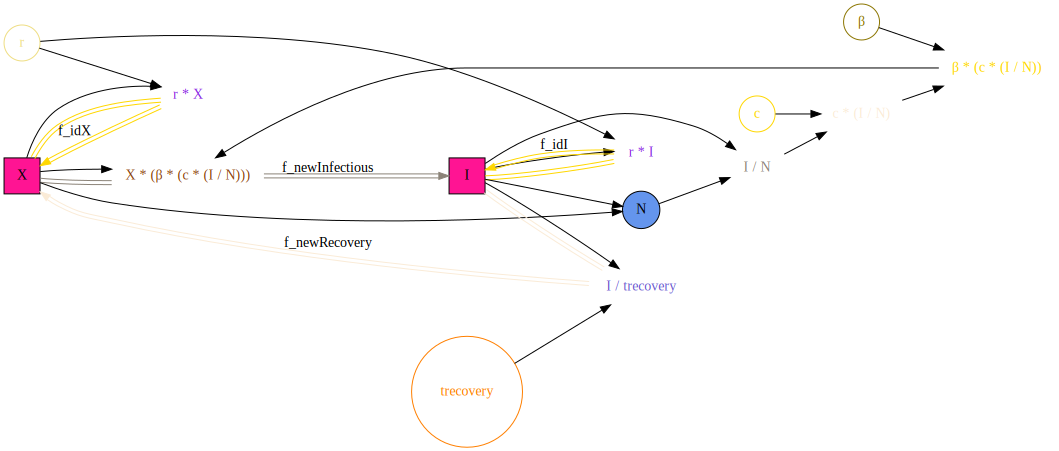

In [44]:
GraphF_typed(sis_pop_strata)